In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm
from IPython.display import display
%matplotlib inline

## Download KITTI
#### http://www.cvlibs.net/datasets/kitti/eval_scene_flow.php?benchmark=stereo

In [5]:
!nvidia-smi

Wed Feb  5 23:49:03 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:01:00.0 Off |                  N/A |
|  0%   24C    P8              23W / 370W |      2MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_scene_flow.zip && unzip data_scene_flow.zip
!mkdir KITTI15
!mv training KITTI15
!mv testing KITTI15

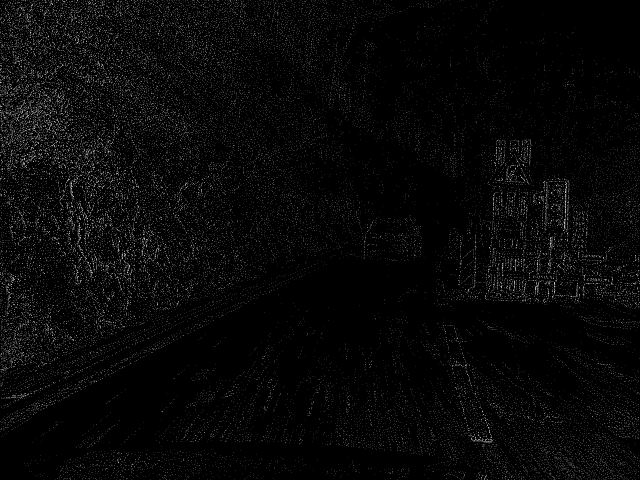

In [6]:
img_id = 10
img = Image.open("./EI_warped/1_log_2000.png")
display(img)

In [ ]:
import shutil
import os
for idx in range(535):
  img0_path = "./EI_warped/"+ str(idx) + "_log_2000.png"
  img1_path = "./interlaken_00_c_images_rectified_right/"+ str(idx).zfill(6) + ".png"  # 右图像路径
  gt_path = "./interlaken_00_c_disparity_image/"+ str(idx).zfill(6) + ".png"   # 视差图路径


In [7]:
import os
import random
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class DSECDataset(Dataset):
    """
    同一个类管理 train/val/test 三种划分。
    
    假设:
    - disparity 文件夹下, 文件名形如 "000000.png", "000002.png" 等 (主索引)
    - event 文件夹下, 对应文件名形如 "0_log_2000.png", "1_log_2000.png" (事件编号 = disparity // 2)
    - frame 文件夹下, 与 disparity 相同命名
    - 仅做 resize，不做裁剪 (可根据需要改动)

    通过 mode='train'/'val'/'test' 设置数据集类型:
    - train: 前 80% (或你自定义)
    - val:   中间 10% (可选)
    - test:  最后 10% (或你自定义)
    """

    def __init__(self,
                 event_dir,
                 frame_dir,
                 disp_dir,
                 transform=None,
                 mode='train',       # 'train' / 'val' / 'test'
                 split_ratios=(0.8, 0.0, 0.2),  # (train_ratio, val_ratio, test_ratio)
                 resize_shape=(640, 480)):
        super().__init__()
        self.event_dir  = event_dir
        self.frame_dir  = frame_dir
        self.disp_dir   = disp_dir
        self.transform  = transform
        self.mode       = mode
        self.resize_w, self.resize_h = resize_shape

        # 从 disparity 文件夹获取主列表 (sorted 确保顺序一致)
        self.disp_files = sorted([f for f in os.listdir(self.disp_dir) if f.endswith('.png')])

        total_num = len(self.disp_files)
        train_ratio, val_ratio, test_ratio = split_ratios
        assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "三者之和应为 1"

        # 计算分割边界
        train_end = int(total_num * train_ratio)
        val_end   = train_end + int(total_num * val_ratio)

        # 根据 mode 设置 start, end 索引
        if self.mode == 'train':
            self.start = 0
            self.end   = train_end
        elif self.mode == 'val':
            self.start = train_end
            self.end   = val_end
        elif self.mode == 'test':
            self.start = val_end
            self.end   = total_num
        else:
            raise ValueError("mode 参数应为 'train'/'val'/'test' 之一")

        self.size = self.end - self.start
        if self.size <= 0:
            raise ValueError(f"{self.mode} 数据集大小为 0，请检查 split_ratios 与文件数量。")

        print(f"[{self.mode}] 集大小: {self.size} (总数: {total_num}) 范围: [{self.start}, {self.end})")

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # 将局部 idx 映射到全局文件列表中的索引
        real_idx = self.start + idx

        # disparity 文件名, 如 "000002.png"
        disp_filename = self.disp_files[real_idx]
        disp_base = int(disp_filename.split('.')[0])  # "000002" -> 2

        # event 文件名 = disp_base // 2
        event_idx = disp_base // 2
        event_filename = f"{event_idx}_log_2000.png"

        # 构造路径
        event_path = os.path.join(self.event_dir,  event_filename)
        frame_path = os.path.join(self.frame_dir,  disp_filename)
        disp_path  = os.path.join(self.disp_dir,   disp_filename)

        # 读取图像
        event_img = Image.open(event_path)  # 事件本身可能是单通道, 先不 convert('RGB')
        frame_img = Image.open(frame_path).convert('RGB')
        disp_img  = Image.open(disp_path)   # disparity 单通道

        # 如果只是单通道, 但是你又希望得到 3 通道(如伪彩色), 你可将 event_img 转为3通道
        # 做法1: 直接复制
        event_img = event_img.convert('L')  # 确保是灰度
        event_img = Image.merge('RGB', (event_img, event_img, event_img))

        # 仅 resize (不裁剪)
        event_img = event_img.resize((self.resize_w, self.resize_h), Image.BILINEAR)
        frame_img = frame_img.resize((self.resize_w, self.resize_h), Image.BILINEAR)
        disp_img  = disp_img.resize((self.resize_w, self.resize_h),  Image.NEAREST)

        # disparity -> numpy, 简单归一化
        disp_np = np.ascontiguousarray(disp_img, dtype=np.float32) / 256.0

        # 若有 transform (如 ToTensor) 对 RGB 图像做处理
        if self.transform:
            event_img = self.transform(event_img)
            frame_img = self.transform(frame_img)
        # disparity 可能保留为 np.array，后续根据网络需求再转 tensor

        return event_img, frame_img, disp_np



In [8]:
!pwd

/stereo


In [22]:
from torch.utils.data import DataLoader
import torchvision.transforms as T

# 你的文件夹路径 (示例)
event_dir = "./EI_warped"
frame_dir = "./interlaken_00_c_images_rectified_right"
disp_dir  = "./interlaken_00_c_disparity_image"

# 这里假设你定义了一套 transform 用于把 PIL 图像转为张量
# 可以根据你的需求再添加归一化、数据增强等
common_transform = T.ToTensor()

# 训练集
train_dataset = DSECDataset(event_dir, frame_dir, disp_dir, 
                            transform=common_transform, 
                            mode='train',
                            split_ratios=(0.8, 0.05, 0.15),  # 三分
                            resize_shape=(640, 480))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)

# 验证集
val_dataset = DSECDataset(event_dir, frame_dir, disp_dir, 
                          transform=common_transform, 
                          mode='val',
                          split_ratios=(0.8, 0.05, 0.15),
                          resize_shape=(640, 480))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

# 测试集
test_dataset = DSECDataset(event_dir, frame_dir, disp_dir, 
                           transform=common_transform, 
                           mode='test',
                           split_ratios=(0.8, 0.05, 0.15),
                           resize_shape=(640, 480))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

print(f"训练集数量: {len(train_dataset)}")
print(f"验证集数量: {len(val_dataset)}")
print(f"测试集数量: {len(test_dataset)}")

# 简单测试一下
for e_img, f_img, disp in test_loader:
    print("Event shape:", e_img.shape)  # [B, 3, H, W]
    print("Frame shape:", f_img.shape)  # [B, 3, H, W]
    print("Disparity shape:", disp.shape)  # [B, H, W] (默认为 numpy，取决于collate_fn)
    break


[train] 集大小: 215 (总数: 269) 范围: [0, 215)
[val] 集大小: 13 (总数: 269) 范围: [215, 228)
[test] 集大小: 41 (总数: 269) 范围: [228, 269)
训练集数量: 215
验证集数量: 13
测试集数量: 41
Event shape: torch.Size([4, 3, 480, 640])
Frame shape: torch.Size([4, 3, 480, 640])
Disparity shape: torch.Size([4, 480, 640])


In [ ]:
# normalize = {'mean': [0.485, 0.456, 0.406],
#                    'std': [0.229, 0.224, 0.225]}
# input_transforms = torchvision.transforms.Compose([T.ToTensor(),
#                                              T.Normalize(**normalize)])
# test_dataset = DSECDataset(event_dir, frame_dir, disp_dir,
#                           transform=input_transforms,
#                           mode='test',
#                           split_ratios=(0.8, 0.05, 0.15),
#                           resize_shape=(640, 480))
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, drop_last=False)
# print('测试集数量:', len(test_dataset))



In [ ]:
# train_dataset = KITTI('./KITTI15/', transform=input_transforms,train=True)
# train_loader = DataLoader(train_dataset, batch_size=4, pin_memory=True, shuffle=True, num_workers=4)

# print('Train Dataset Size:', len(train_dataset))

## Create Basic Model

In [11]:
def conv_bn(dim, in_planes, out_planes, kernel_size, stride, pad, dilation=None):
  if dim == 2:
    return nn.Sequential(
        nn.Conv2d(in_channels=in_planes, out_channels=out_planes, kernel_size=kernel_size, stride=stride, padding=dilation if dilation > 1 else pad, dilation=dilation, bias=False),
        nn.BatchNorm2d(out_planes)
    )
  elif dim == 3:
    return nn.Sequential(
        nn.Conv3d(in_channels=in_planes, out_channels=out_planes, kernel_size=kernel_size, padding=pad, stride=stride, bias=False),
        nn.BatchNorm3d(out_planes)
    )  

class DisparityRegression(nn.Module):
  def __init__(self, max_disp):
    super(DisparityRegression, self).__init__()
    self.disp = Variable(torch.Tensor(np.reshape(np.array(range(max_disp)), [1, max_disp, 1, 1])).cuda(), requires_grad=False)

  def forward(self, x):
    disp = self.disp.repeat(x.size()[0], 1, x.size()[2], x.size()[3])
    out = torch.sum(x*disp, 1)

    return out

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, in_channels, 1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.conv_sc = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        self.bn_sc = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(y)))
        y = self.bn3(self.conv3(y))

        x = self.conv_sc(x)
        x = self.bn_sc(x)

        y += x
        y = F.relu(y)

        return y


class IdentityBlock(nn.Module):
    def __init__(self, in_channels):
        super(IdentityBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, in_channels, 1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, 1)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        y += x
        y = F.relu(y)

        return y


class Feature(nn.Module):
    def __init__(self):
        super(Feature, self).__init__()


        self.conv1 = nn.Sequential(ConvBlock(3,32,3,1),
                                  IdentityBlock(32),
                                  IdentityBlock(32),
                                  IdentityBlock(32),
                                  IdentityBlock(32),
                                  ConvBlock(32,64,3,1),
                                  IdentityBlock(64),
                                  IdentityBlock(64),
                                  IdentityBlock(64),
                                  IdentityBlock(64),
                                  )
        
        self.conv2 = nn.Sequential(ConvBlock(3,32,3,1),
                          IdentityBlock(32),
                          IdentityBlock(32),
                          IdentityBlock(32),
                          IdentityBlock(32),
                          ConvBlock(32,64,3,1),
                          IdentityBlock(64),
                          IdentityBlock(64),
                          IdentityBlock(64),
                          IdentityBlock(64),
                          )
        
        self.conv3 = nn.Sequential(ConvBlock(3,32,3,1),
                          IdentityBlock(32),
                          IdentityBlock(32),
                          IdentityBlock(32),
                          IdentityBlock(32),
                          ConvBlock(32,64,3,1),
                          IdentityBlock(64),
                          IdentityBlock(64),
                          IdentityBlock(64),
                          IdentityBlock(64),
                          )
        
        self.conv4 = nn.Sequential(ConvBlock(3,32,3,1),
                          IdentityBlock(32),
                          IdentityBlock(32),
                          IdentityBlock(32),
                          IdentityBlock(32),
                          ConvBlock(32,64,3,1),
                          IdentityBlock(64),
                          IdentityBlock(64),
                          IdentityBlock(64),
                          IdentityBlock(64),
                          )

        self.final_conv = nn.Sequential(ConvBlock(64*4, 128, 3, 1),
                                        IdentityBlock(128),
                                        IdentityBlock(128),
                                        IdentityBlock(128),
                                        IdentityBlock(128),
                                        ConvBlock(128, 64, 3, 1),
                                        IdentityBlock(64),
                                        IdentityBlock(64),
                                        IdentityBlock(64),
                                        IdentityBlock(64),
                                        nn.Conv2d(64,32,1)
                                        )

    def forward(self, x):
        x1 = self.conv1(F.avg_pool2d(x, 4))
        x2 = self.conv2(F.avg_pool2d(x, 8))
        x3 = self.conv3(F.avg_pool2d(x, 16))
        x4 = self.conv4(F.avg_pool2d(x, 32))

        x2 = F.interpolate(x2, (x1.shape[2], x1.shape[3]), mode = 'bilinear')
        x3 = F.interpolate(x3, (x1.shape[2], x1.shape[3]), mode = 'bilinear')
        x4 = F.interpolate(x4, (x1.shape[2], x1.shape[3]), mode = 'bilinear')

        y = torch.cat((x1,x2,x3,x4), dim=1)
        y = F.dropout2d(y)
        y = self.final_conv(y)

        return y

In [12]:
class PSMNet(nn.Module):
  def __init__(self, max_disp):
    super(PSMNet, self).__init__()
    self.maxdisp = max_disp
    self.feature_extraction = Feature()

    self.res0 = nn.Sequential(
      conv_bn(3, 64, 32, 3, 1, 1),
      nn.ReLU(inplace=True),
      conv_bn(3, 32, 32, 3, 1, 1),
      nn.ReLU(inplace=True)
    )
    self.res1 = nn.Sequential(
      conv_bn(3, 32, 32, 3, 1, 1),
      nn.ReLU(inplace=True),
      conv_bn(3, 32, 32, 3, 1, 1),
    )
    self.res2 = nn.Sequential(
      conv_bn(3, 32, 32, 3, 1, 1),
      nn.ReLU(inplace=True),
      conv_bn(3, 32, 32, 3, 1, 1)
    )
    self.res3 = nn.Sequential(
      conv_bn(3, 32, 32, 3, 1, 1),
      nn.ReLU(inplace=True), 
      conv_bn(3, 32, 32, 3, 1, 1)
    )
    self.res4 = nn.Sequential(
      conv_bn(3, 32, 32, 3, 1, 1),
      nn.ReLU(inplace=True),
      conv_bn(3, 32, 32, 3, 1, 1)
    )
    self.classify = nn.Sequential(
      conv_bn(3, 32, 32, 3, 1, 1),
      nn.ReLU(inplace=True),
      nn.Conv3d(32, 1, kernel_size=3, padding=1, stride=1, bias=False)
    )

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, np.sqrt(2. / n))
      elif isinstance(m, nn.Conv3d):
        n = m.kernel_size[0] * m.kernel_size[1]*m.kernel_size[2] * m.out_channels
        m.weight.data.normal_(0, np.sqrt(2. / n))
      elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm3d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
      elif isinstance(m, nn.Linear):
        m.bias.data.zero_()

  def forward(self, left, right):
    ref_img_fea = self.feature_extraction(left)
    target_img_fea  = self.feature_extraction(right)

    cost = Variable(torch.FloatTensor(ref_img_fea.size()[0], ref_img_fea.size()[1]*2, self.maxdisp//4,  ref_img_fea.size()[2],  ref_img_fea.size()[3]).zero_(), volatile= not self.training).cuda()

    for i in range(self.maxdisp//4):
      if i > 0:
        cost[:, :ref_img_fea.size()[1], i, :,i:] = ref_img_fea[:,:,:,i:]
        cost[:, ref_img_fea.size()[1]:, i, :,i:] = target_img_fea[:,:,:,:-i]
      else:
        cost[:, :ref_img_fea.size()[1], i, :,:] = ref_img_fea
        cost[:, ref_img_fea.size()[1]:, i, :,:] = target_img_fea
    cost = cost.contiguous()

    cost0 = self.res0(cost)
    cost0 = self.res1(cost0) + cost0
    cost0 = self.res2(cost0) + cost0 
    cost0 = self.res3(cost0) + cost0 
    cost0 = self.res4(cost0) + cost0

    cost = self.classify(cost0)
    cost = F.interpolate(cost, [self.maxdisp,left.size()[2], left.size()[3]], mode='trilinear', align_corners=False)
    cost = torch.squeeze(cost, 1)
    pred = F.softmax(cost)
    pred = DisparityRegression(self.maxdisp)(pred)

    return pred

## Train Model

In [23]:
# Define network and training parameters
torch.cuda.empty_cache()
model = PSMNet(192)
device = torch.device("cuda")
model.to(device)
print(model)

num_epochs = 100
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

PSMNet(
  (feature_extraction): Feature(
    (conv1): Sequential(
      (0): ConvBlock(
        (conv1): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
        (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv_sc): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
        (bn_sc): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): IdentityBlock(
        (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [24]:
def Test_Acc(model2,test_loader):
  def test(imgL,imgR,disp_true):

        model2.eval()
        imgL   = Variable(torch.FloatTensor(imgL))
        imgR   = Variable(torch.FloatTensor(imgR))   
        imgL, imgR = imgL.cuda(), imgR.cuda()

        with torch.no_grad():
            output3 = model2(imgL,imgR)

        pred_disp = output3.data.cpu()
        true_disp = disp_true.clone()
        
        array = np.zeros(true_disp.shape)
        array[true_disp>0] = 1

        greater_than_one = len(array[array==1])

        disp_true = np.abs(true_disp-pred_disp.numpy())
        disp_true = disp_true*array
        error = len(disp_true[disp_true>3])

        return float(error)/float(greater_than_one)

  Error = []
  for i, (imgL, imgR, disp_L) in enumerate(test_loader):
        Error.append(1-test(imgL,imgR,disp_L))

  print(f'Final Accuracy: {np.mean(np.array(Error))}')
  return np.mean(np.array(Error))

In [25]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params,pytorch_total_trainable_params)

1702344 1702344


In [26]:
# Train loop
import time
import numpy as np
import pandas as pd
# from google.colab import files
optimizer = optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=5, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
model.train()
avg_loss = []
start_time = time.time()
Acc = []
for epoch in range(num_epochs):
    total_train_loss = 0
    for i, (imgL, imgR, disp_L) in enumerate(train_loader):
      imgL = Variable(torch.FloatTensor(imgL)).to(device)
      imgR = Variable(torch.FloatTensor(imgR)).to(device)   
      disp_L = Variable(torch.FloatTensor(disp_L)).to(device)

      mask = (disp_L > 0)
      mask.detach_()

      optimizer.zero_grad()
      out = model(imgL, imgR)
      out = torch.squeeze(out, 1)
      loss = F.smooth_l1_loss(out[mask], disp_L[mask], size_average=True)

      loss.backward()
      optimizer.step()
      avg_loss.append(loss.item())
      if i%5==0:
        print('Epoch: {0}, Iter: {1}, Training Loss: {2}'.format(epoch, i, loss))

      total_train_loss += loss.item()

      torch.cuda.empty_cache()
      del imgL
      del imgR
      del disp_L
      del out
      del loss


    scheduler.step(np.mean(avg_loss))
    print(f'Scheduler saw loss: {np.mean(avg_loss)}')
    print(f'Time: {(time.time()-start_time)/60} \n') 
    model.eval()
    Acc.append(Test_Acc(model,test_loader))
    
    model.train()
    if epoch % 10 == 0:
      print(f'Saving the model at Epoch: {epoch}, Average Loss: {np.mean(avg_loss)} as Model_V2_Epoch_{epoch}')
      torch.save(model.state_dict(), f'Model_V2_Epoch_{epoch}.pt')
      #files.download(f'Model_V2_Epoch_{epoch}.pt')
      index = [f'Epoch {i}' for i in range(len(Acc))]
      Accuracy_Values = {f'Test Accuracy':Acc}
#       df_accuracy = pd.DataFrame(Acc uracy_Values,index=index)
#       df_accuracy.to_csv(f'Accuracy_Values_Epoch_{epoch}.csv')
#       files.download(f'Accuracy_Values_Epoch_{epoch}.csv')

    avg_loss = []



/tmp/ipykernel_870/3023281895.py:76: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(cost)


Epoch: 0, Iter: 0, Training Loss: 49.90946960449219
Epoch: 0, Iter: 5, Training Loss: 45.58547592163086
Epoch: 0, Iter: 10, Training Loss: 27.000551223754883
Epoch: 0, Iter: 15, Training Loss: 24.054344177246094
Epoch: 0, Iter: 20, Training Loss: 25.710126876831055
Epoch: 0, Iter: 25, Training Loss: 16.602108001708984
Epoch: 0, Iter: 30, Training Loss: 20.18353843688965
Epoch: 0, Iter: 35, Training Loss: 15.905577659606934
Epoch: 0, Iter: 40, Training Loss: 17.496065139770508
Epoch: 0, Iter: 45, Training Loss: 17.889888763427734
Epoch: 0, Iter: 50, Training Loss: 15.508151054382324
Scheduler saw loss: 24.362870445957892
Time: 1.3839566787083943 



/tmp/ipykernel_870/3023281895.py:56: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  cost = Variable(torch.FloatTensor(ref_img_fea.size()[0], ref_img_fea.size()[1]*2, self.maxdisp//4,  ref_img_fea.size()[2],  ref_img_fea.size()[3]).zero_(), volatile= not self.training).cuda()
/tmp/ipykernel_870/4150979020.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  disp_true = np.abs(true_disp-pred_disp.numpy())
/tmp/ipykernel_870/4150979020.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  disp_true = disp_true*array


Final Accuracy: 0.13171326899762878
Saving the model at Epoch: 0, Average Loss: 24.362870445957892 as Model_V2_Epoch_0
Epoch: 1, Iter: 0, Training Loss: 18.033727645874023
Epoch: 1, Iter: 5, Training Loss: 15.462674140930176
Epoch: 1, Iter: 10, Training Loss: 16.57048988342285
Epoch: 1, Iter: 15, Training Loss: 13.869613647460938
Epoch: 1, Iter: 20, Training Loss: 15.74655532836914
Epoch: 1, Iter: 25, Training Loss: 14.592364311218262
Epoch: 1, Iter: 30, Training Loss: 12.881834030151367
Epoch: 1, Iter: 35, Training Loss: 17.164005279541016
Epoch: 1, Iter: 40, Training Loss: 15.862959861755371
Epoch: 1, Iter: 45, Training Loss: 13.37346076965332
Epoch: 1, Iter: 50, Training Loss: 12.83519172668457
Scheduler saw loss: 14.926921738518608
Time: 2.836366275946299 

Final Accuracy: 0.1345663531145757
Epoch: 2, Iter: 0, Training Loss: 12.827522277832031
Epoch: 2, Iter: 5, Training Loss: 11.873867988586426
Epoch: 2, Iter: 10, Training Loss: 15.28885555267334
Epoch: 2, Iter: 15, Training Loss:

In [28]:
torch.save(model.state_dict(), f'model_V4_Modified_Epoch_{epoch}.pt')
torch.save(optimizer.state_dict(), 'optimizer.pt')
torch.save(scheduler.state_dict(), 'scheduler.pt')

In [33]:
model2 = PSMNet(192)
model2.load_state_dict(torch.load('Model_V2_Epoch_90.pt'));
model2.eval()
device = torch.device("cuda")
model2.to(device)

/tmp/ipykernel_870/924301391.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('Model_V2_Epoch_90.pt'));


PSMNet(
  (feature_extraction): Feature(
    (conv1): Sequential(
      (0): ConvBlock(
        (conv1): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
        (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv_sc): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
        (bn_sc): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): IdentityBlock(
        (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

/tmp/ipykernel_870/3023281895.py:56: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  cost = Variable(torch.FloatTensor(ref_img_fea.size()[0], ref_img_fea.size()[1]*2, self.maxdisp//4,  ref_img_fea.size()[2],  ref_img_fea.size()[3]).zero_(), volatile= not self.training).cuda()
/tmp/ipykernel_870/3023281895.py:76: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(cost)


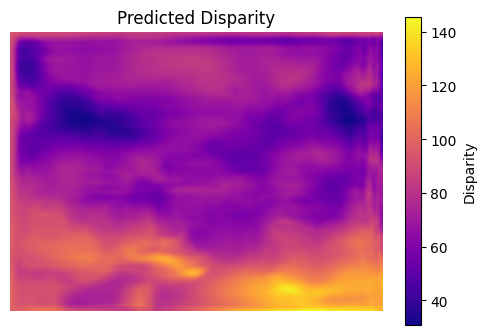

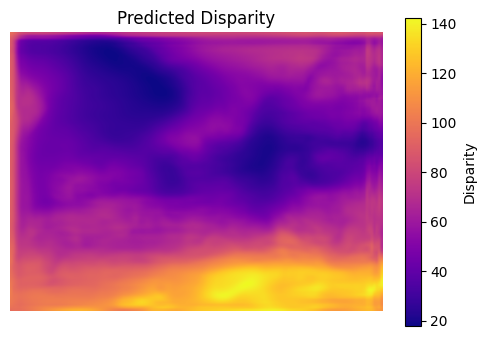

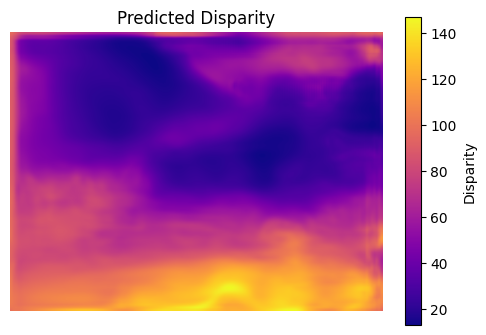

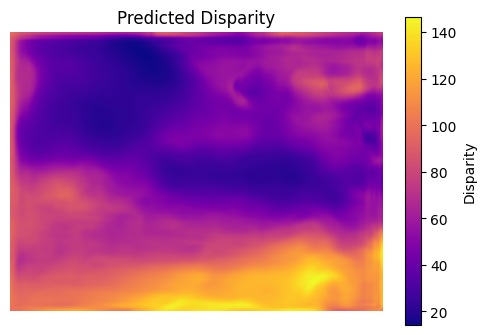

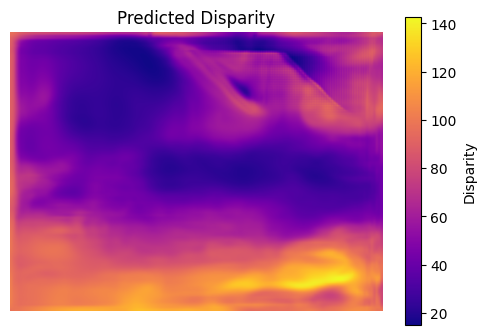

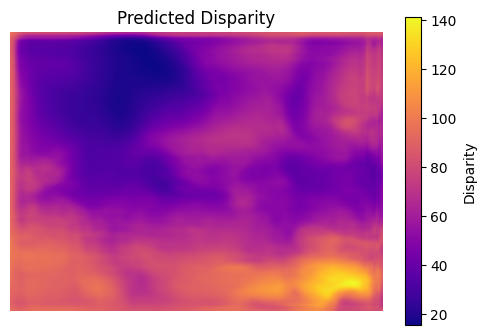

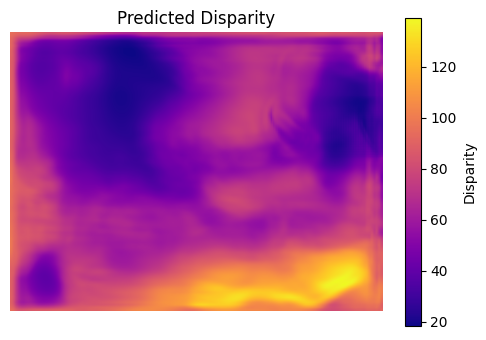

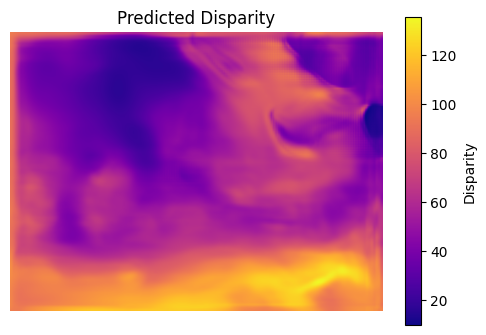

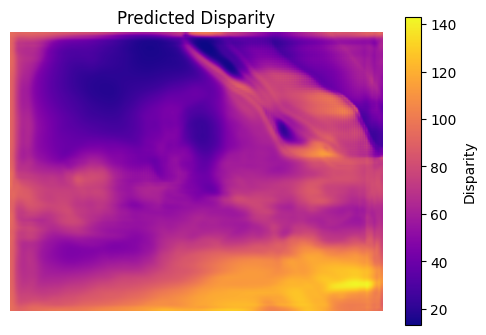

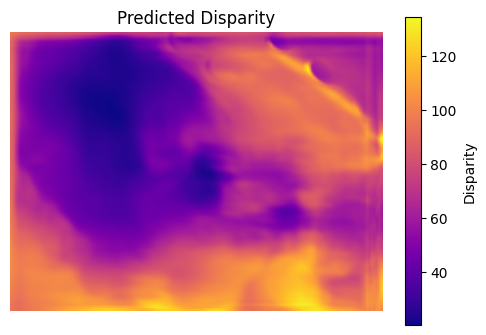

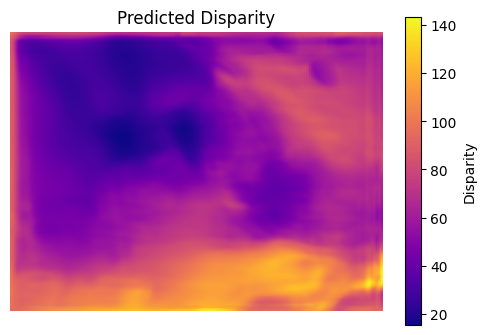

Test set MAE: 60.700,  RMSE: 67.684


In [38]:
import numpy as np
import torch
import torch.nn.functional as F

# 你已有的两个函数，也可内联在 evaluate_model 中
def MAE(pred, gt):
    """
    对应绝对误差的平均值 (Mean Absolute Error).
    其中 pred, gt 都是 numpy array, shape=(H, W).
    只统计 (pred >= 0) & (gt >= 0) & 非 NaN 的像素.
    """
    mask = (pred >= 0) & (gt >= 0) & np.isfinite(pred) & np.isfinite(gt)
    pred_valid = pred[mask]
    gt_valid   = gt[mask]
    if pred_valid.size == 0:  # 如果掩码下没有有效像素
        return 0.0
    return np.mean(np.abs(pred_valid - gt_valid))

def RMSE(pred, gt):
    """
    对应均方根误差 (Root Mean Squared Error).
    """
    mask = (pred >= 0) & (gt >= 0) & np.isfinite(pred) & np.isfinite(gt)
    pred_valid = pred[mask]
    gt_valid   = gt[mask]
    if pred_valid.size == 0:
        return 0.0
    return np.sqrt(np.mean((pred_valid - gt_valid)**2))

def evaluate_model(model, test_loader):
    """
    对 test_loader 中的所有样本进行推断，并计算整体 MAE / RMSE 平均值。
    """
    model.eval()
    mae_list  = []
    rmse_list = []

    with torch.no_grad():
        for e_img, f_img, disp_np in test_loader:
            # e_img, f_img 是 (B, 3, H, W) 的张量
            e_img = e_img.cuda()
            f_img = f_img.cuda()

            # 前向推断得到 (B, H, W) 的预测结果
            pred = model(e_img, f_img)  
            # 若你的模型输出 (B, 1, H, W)，可先 pred = pred.squeeze(1)
            
            # 转为 numpy
            pred_cpu = pred.cpu().numpy()      # shape: (B, H, W)
            gt_cpu   = disp_np.numpy()         # shape: (B, H, W)
            plt.figure(figsize=(6, 4))
            plt.imshow(pred_cpu[0], cmap='plasma')  # 你也可试 'jet', 'magma' 等
            plt.colorbar(label='Disparity')
            plt.title('Predicted Disparity')
            plt.axis('off')
            plt.show()
            # 对 batch 内每张图分别计算 MAE / RMSE
            for b_idx in range(pred_cpu.shape[0]):
                pred_b = pred_cpu[b_idx]
                gt_b   = gt_cpu[b_idx]
                mae_val  = MAE(pred_b, gt_b)
                rmse_val = RMSE(pred_b, gt_b)
                mae_list.append(mae_val)
                rmse_list.append(rmse_val)

    # 整个测试集的平均值
    mean_mae  = np.mean(mae_list)
    mean_rmse = np.mean(rmse_list)
    return mean_mae, mean_rmse

# =======================
# 用法示例
# =======================
# 假设你已经实例化了 test_loader，并且 model 已经加载了权重:

mae, rmse = evaluate_model(model2, test_loader)
print(f"Test set MAE: {mae:.3f},  RMSE: {rmse:.3f}")


In [32]:
mae_list = []
rmse_list = []

for i, (imgL, imgR, dispL) in enumerate(test_loader):
    print("Infering", i)
    mae_val, rmse_val = predict(i, imgL, imgR, dispL, model, save_dir="pred")
    mae_list.append(mae_val)
    rmse_list.append(rmse_val)

print("Average MAE:",  np.mean(mae_list))
print("Average RMSE:", np.mean(rmse_list))


Infering 0


/tmp/ipykernel_870/3023281895.py:56: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  cost = Variable(torch.FloatTensor(ref_img_fea.size()[0], ref_img_fea.size()[1]*2, self.maxdisp//4,  ref_img_fea.size()[2],  ref_img_fea.size()[3]).zero_(), volatile= not self.training).cuda()
/tmp/ipykernel_870/3023281895.py:76: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(cost)


FileNotFoundError: [Errno 2] No such file or directory: '/stereo/pred/pred_0.png'

In [27]:
def predict(i, imgL,imgR, DispL):

    model.eval()
    imgL   = Variable(torch.FloatTensor(imgL))
    imgR   = Variable(torch.FloatTensor(imgR))   
    imgL, imgR = imgL.cuda(), imgR.cuda()

    with torch.no_grad():
        output3 = model(imgL,imgR)

    pred_disp = np.squeeze(output3.data.cpu().numpy())
    true_disp = np.squeeze(DispL.data.cpu().numpy())
    
    pred_disp = Image.fromarray((pred_disp*256).astype('uint16'))
    pred_disp.save("pred/"+str(i)+".png")
    
    true_disp = Image.fromarray((true_disp*256).astype('uint16'))
    true_disp.save("GT/" + str(i)+".png")  

In [ ]:
for i, (imgL, imgR, DispL) in enumerate(submission_loader):
    print("Inferring",i)
    predict(i, imgL, imgR, DispL)